## 2.高维线性回归实验

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd, gluon, init
from mxnet.gluon import loss as gloss, nn, data as gdata

n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = nd.ones((num_inputs, 1)) * 0.01, 0.05

features = nd.random.normal(shape = (n_train + n_test, num_inputs))
labels = nd.dot(features, true_w) + true_b
labels += nd.random.normal(scale = 0.01, shape = labels.shape)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 2.从零开始实现

In [2]:
def init_params():
    w = nd.random.normal(scale = 1, shape = (num_inputs, 1))
    b = nd.zeros(shape = (1,))
    w.attach_grad()
    b.attach_grad()
    return [w, b]

In [3]:
def L2_penalty(w):
    return (w**2).sum() / 2

In [4]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss
train_iter = d2l.gdata.DataLoader(d2l.gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle = True)

def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, w, b), y) + lambd * L2_penalty(w)
            l.backward()
            d2l.sgd([w, b], lr, batch_size)

        train_ls.append(loss(net(train_features, w, b), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().asscalar())
    
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().asscalar())

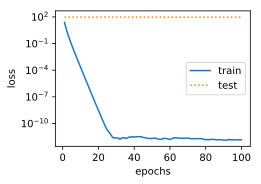

L2 norm of w: 13.155677


In [ ]:
# 不使用权重衰减，观察过拟合现象，训练误差明显小于测试误差
fit_and_plot(0)

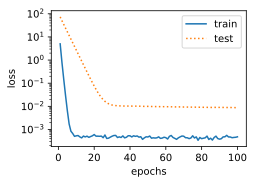

L2 norm of w: 0.041794162


In [ ]:
# 使用权重衰减，虽然训练误差有所提高，但是降低了泛化误差
fit_and_plot(3)

## 4.简洁实现

In [13]:
def fit_and_plot_gluon(wd):
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize(init.Normal(sigma = 0.01))

    # 对权重参数衰减。权重名称⼀般是以weight结尾
    trainer_w = gluon.Trainer(net.collect_params('.*weight'), 'sgd', {'learning_rate': lr, 'wd': wd})
    # 不对偏差参数衰减。偏差名称⼀般是以bias结尾
    trainer_b = gluon.Trainer(net.collect_params('.*bias'), 'sgd', {'learning_rate': lr})

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            # 对两个Trainer实例分别调⽤step函数，从⽽分别更新权重和偏差
            trainer_w.step(batch_size)
            trainer_b.step(batch_size)
        train_ls.append(loss(net(train_features), train_labels).mean().asscalar())
        test_ls.append(loss(net(test_features), test_labels).mean().asscalar())
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net[0].weight.data().norm().asscalar())

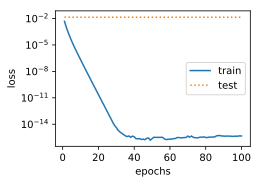

L2 norm of w: 0.13726589


In [14]:
fit_and_plot_gluon(0)

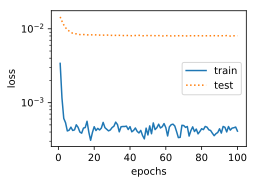

L2 norm of w: 0.042369448


In [15]:
fit_and_plot_gluon(3)